### Read packages, define cleaning and ploting functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def concat_data(data_2019, data_2020, data_2021):

    df_20 = pd.read_csv("data/output/" + data_2020)
    df_20["year"] = "2020"
    df_20["month"] = df_20["site_month"].str.split("_").apply(lambda x: x[1])

    df_21 = pd.read_csv("data/output/" + data_2021)
    df_21["year"] = "2021"

    df_21["month"] = df_21["site_month"].str.split("_").apply(lambda x: x[1])
    df_21["month"] = df_21["month"].astype(int)

    df_19 = pd.read_csv("data/output/" + data_2019)
    df_19["year"] = "2019"
    df_19["month"] = df_19["site_month"].str.split("_").apply(lambda x: x[1])
    df_19["month"] = df_19["month"].astype(int)

    return pd.concat([df_19, df_20, df_21])

In [142]:
def format_df(df, z_score=1.96):
    return (
        df.assign(
            site=lambda x: x["site_month"].str.split("_").str[0],
            date=lambda x: pd.to_datetime(
                x["site_month"].str.split("_").str[1:3].str.join(sep=""), format="%Y%m"
            ),
            ci_lower=lambda x: x["fit"] - z_score * x["se.fit"],
            ci_upper=lambda x: x["fit"] + z_score * x["se.fit"],
        )
        .melt(id_vars=["site", "date"], value_vars=["fit", "ci_lower", "ci_upper"])
        .assign(
            variable_type=lambda x: x["variable"],
            variable=lambda x: x["variable"].map(
                {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
            ),
        )
        .assign(site=lambda x: np.where(x["site"] == "24hu", "24.hu", x["site"]))
        .assign(site=lambda x: np.where(x["site"] == "index", "Index", x["site"]))
        .rename(columns={"value": "slant"})
        .sort_values(by=["site", "date"])
    )

In [4]:
def format_pred(df):
    df["site"] = df["site_month"].str.split("_").apply(lambda x: x[0])

    z_score = 1.96
    df["ci_lower"] = df["fit"] - z_score * df["se.fit"]
    df["ci_upper"] = df["fit"] + z_score * df["se.fit"]

    df = df.melt(
        id_vars=["site", "year", "month"], value_vars=["fit", "ci_lower", "ci_upper"]
    )
    df["variable_type"] = df["variable"]
    df["variable"] = df["variable"].map(
        {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
    )

    df = df.rename(columns={"value": "slant"})

    df["date"] = pd.to_datetime(
        df["year"].astype(str) + df["month"].astype(str), format="%Y%m"
    )

    df["site"] = np.where(df["site"] == "24hu", "24.hu", df["site"])
    df["site"] = np.where(df["site"] == "index", "Index", df["site"])

    df = df.sort_values(by=["site", "date"])

    return df

In [5]:
def plot_slant(df, figname):
    plt.figure(figsize=(10, 7))
    sns.set_theme(style="darkgrid")
    sns.lineplot(
        x="date",
        y="slant",
        hue="site",
        style="variable",
        data=df.loc[
            lambda x: (x["date"] != df["date"].values[-1])
            & (x["date"] != df["date"].values[-2])
        ],
    )
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.savefig("figures/" + figname)
    plt.show()

In [6]:
def plot_smooth_slant(df, figname, rolling_window=4):

    rolling_mean = (
        df.loc[lambda x: x.variable_type == "fit"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    rolling_mean_upper = (
        df.loc[lambda x: x.variable_type == "ci_upper"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    rolling_mean_lower = (
        df.loc[lambda x: x.variable_type == "ci_lower"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    df_rolling = pd.concat(
        [
            df.loc[lambda x: x.variable_type == "fit"].assign(
                rolling_mean=rolling_mean
            ),
            df.loc[lambda x: x.variable_type == "ci_upper"].assign(
                rolling_mean=rolling_mean_upper
            ),
            df.loc[lambda x: x.variable_type == "ci_lower"].assign(
                rolling_mean=rolling_mean_lower
            ),
        ]
    ).reset_index(drop=True)

    df["variable"] = df["variable_type"].map(
        {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
    )

    plt.figure(figsize=(10, 7))
    sns.set_theme(style="darkgrid")
    sns.lineplot(
        x="date", y="rolling_mean", hue="site", style="variable", data=df_rolling
    )
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.title("Predicted slant of media outlets by month\nbased on Gentzkow-Shapiro (2010)",size=20)
    plt.ylabel("slant")
    plt.savefig("figures/" + figname)
    plt.show()

### initial model
- trained on 19-20 speeches
- 1000 bigrams, 1000 trigrams

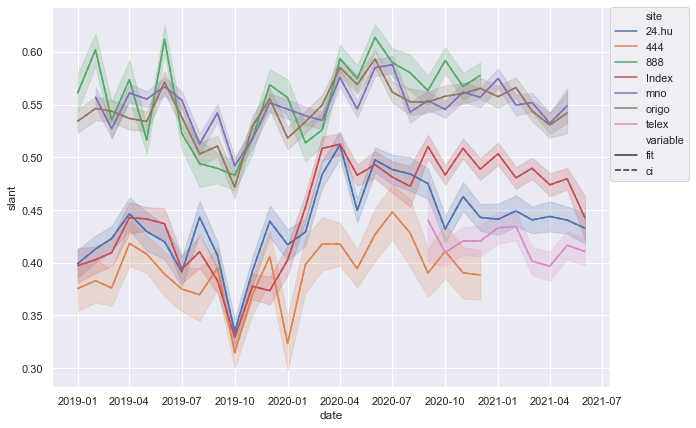

In [15]:
df = concat_data(
    "monthly_pred_1920_2019_v2.csv",
    "monthly_pred_1920_v2.csv",
    "monthly_pred_1920_2021_v2.csv",
)
df = format_pred(df)

plot_slant(df,"slant_bymonth_1920.png")

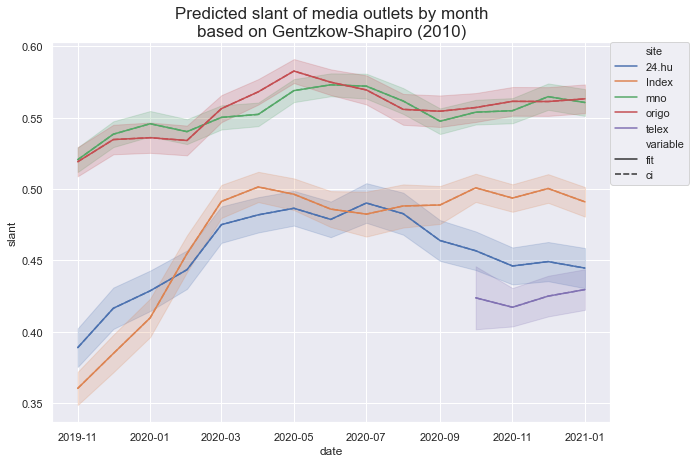

In [51]:
plot_smooth_slant(
    df.loc[
        lambda x: (x.date > "2019-09-01")
        & (~x.site.isin(["888", "444"]))
        & (x.date < "2021-03-01")
    ],
    "slant_bymonth_1920_mindenki.png",
    rolling_window=3,
)

### model 2
- trained on 18-20 speeches
- 1000 unigrams, 1000 bigrams, 1000 trigrams

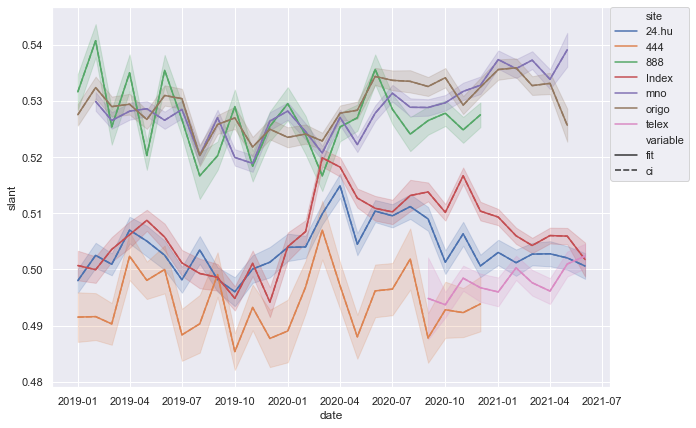

In [61]:
df = concat_data(
    "monthly_pred_1820_2019_wuni.csv",
    "monthly_pred_1820_wuni.csv",
    "monthly_pred_1820_2021_wuni.csv",
)

df = format_pred(df)

plot_slant(df,"slant_bymonth_1820.png")

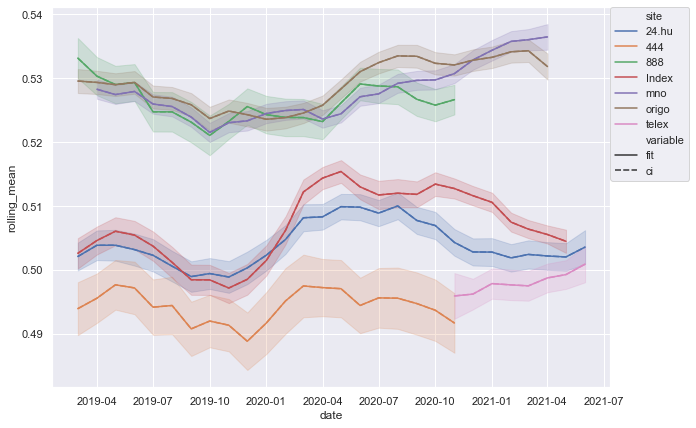

In [62]:
plot_smooth_slant(df, "slant_bymonth_1820_smooth.png")

### model 3
- trained on 18-20 speeches
- only unigrams, but used all

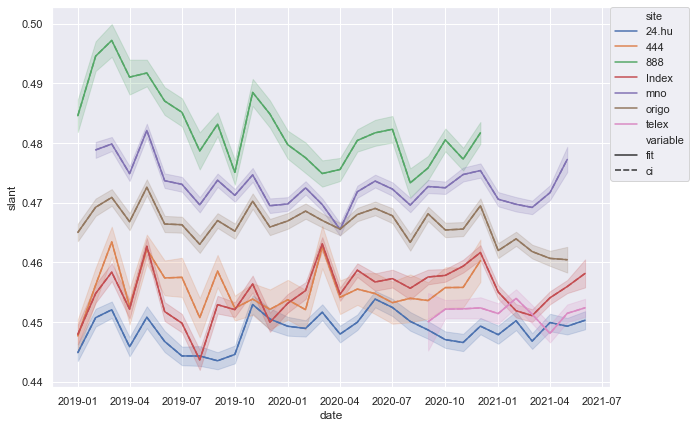

In [63]:
df = concat_data(
    "monthly_pred_1820_2019_unionly.csv",
    "monthly_pred_1820_unionly.csv",
    "monthly_pred_1820_2021_unionly.csv",
)

df = format_pred(df)

plot_slant(df,"slant_bymonth_1820_unigram.png")

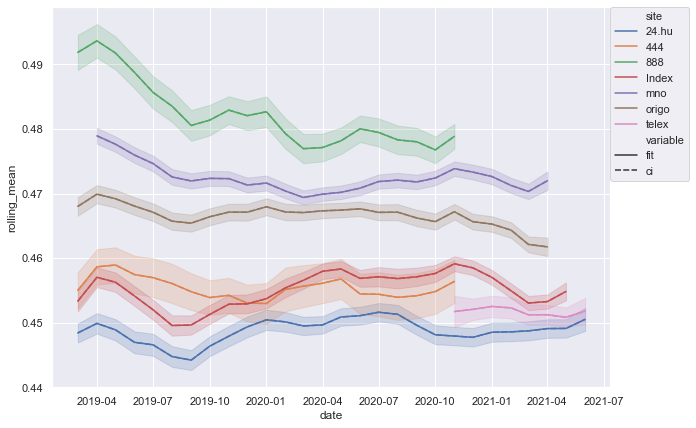

In [64]:
plot_smooth_slant(df, "slant_bymonth_1820_unigram_smooth.png")

### model 4
- trained on 18-20 speeches
- 1000-1000 bi-trigrams
- smoothing parameter not used
- trained on individual speeches

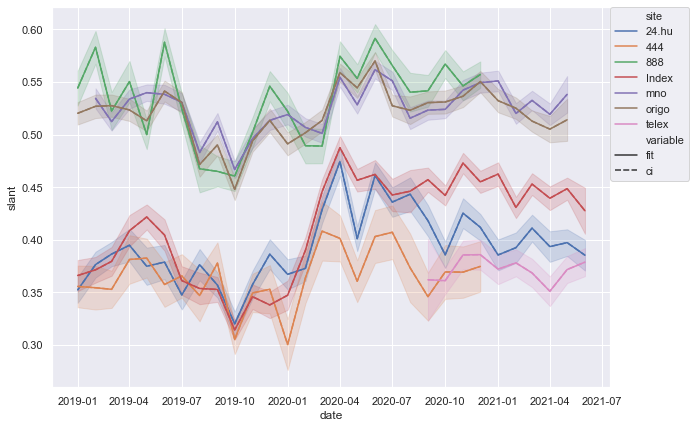

In [71]:
df = concat_data(
    "monthly_pred_1820_2019_predspeech.csv",
    "monthly_pred_1820_predspeech.csv",
    "monthly_pred_1820_2021_predspeech.csv",
)

df = format_pred(df)

plot_slant(df,"slant_bymonth_1820_predspeech.png")

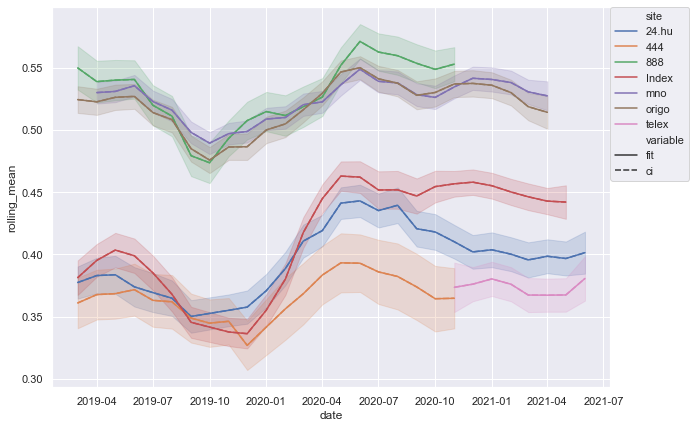

In [73]:
plot_smooth_slant(df, "slant_bymonth_1820_predspeech_smooth.png",rolling_window=4)

### model 5
- trained on 14-18 speeches
- 1000-1000 bi-trigrams
- smoothing parameter not used
- trained on individual speeches

In [18]:
df = concat_data(
    "monthly_pred_1418_2019_predspeech.csv",
    "monthly_pred_1418_predspeech.csv",
    "monthly_pred_1418_2021_predspeech.csv",
)

df = format_pred(df)

In [60]:
plot_slant(
    df.loc[lambda x: x.date > "2019-09-01"],
    "slant_bymonth_1418_predspeech_mindenki.png",
)

AttributeError: 'DataFrame' object has no attribute 'date'

## model 6
- trained on 14-18 speeches, without Jobbik
- 1000-1000 bi-trigrams
- smoothing parameter not used
- trained on individual speeches

In [143]:
df = pd.read_csv("data/output/" + "monthly_pred_1418_wojobbik.csv")
df = format_df(df)
df["site"] = df.site.map(
    {
        "24.hu": "24.hu",
        "Index": "index.hu",
        "telex": "telex.hu",
        "mno": "magyarnemzet.hu",
        "origo": "origo.hu",
        "444": "444.hu",
        "888": "888.hu",
    }
)

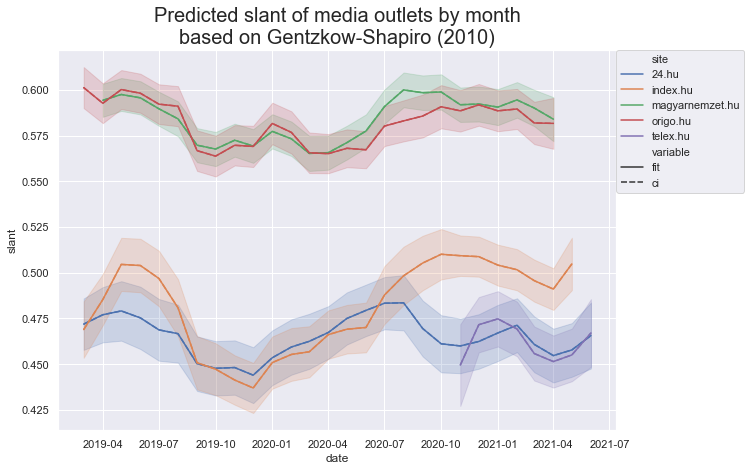

In [144]:
plot_smooth_slant(
    df.loc[lambda x: (x["site"] != "888.hu") & (x["site"] != "444.hu")],
    "slant_bymonth_1418_predspeech_wojobbik.png",
    rolling_window=4,
)

## read readership numbers

In [128]:
def format_for_plot(df):
    return (
        df.melt(id_vars=["site", "date"], value_vars=["fit", "ci_lower", "ci_upper"])
        .assign(
            variable_type=lambda x: x["variable"],
            variable=lambda x: x["variable"].map(
                {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
            ),
        )
        .assign(site=lambda x: np.where(x["site"] == "24hu", "24.hu", x["site"]))
        .assign(site=lambda x: np.where(x["site"] == "index", "Index", x["site"]))
        .rename(columns={"value": "slant"})
        .sort_values(by=["site", "date"])
    )

In [145]:
readership = (
    pd.read_csv("../hyperlink network stuff/data/real_users.csv")
    .rename({"page": "site"}, axis=1)
    .assign(date=lambda x: pd.to_datetime(x["date"], format="%Y-%m-%d"))
)

df = (
    pd.read_csv("data/output/" + "monthly_pred_1418_wojobbik.csv")
    .assign(
        site=lambda x: x["site_month"].str.split("_").str[0],
        date=lambda x: pd.to_datetime(
            x["site_month"].str.split("_").str[1:3].str.join(sep=""), format="%Y%m"
        ),
    )
    .assign(site=lambda x: np.where(x["site"] == "24hu", "24.hu", x["site"]))
    .assign(site=lambda x: np.where(x["site"] == "index", "Index", x["site"]))
    .assign(
        site=lambda x: x["site"].map(
            {
                "24.hu": "24.hu",
                "Index": "index.hu",
                "telex": "telex.hu",
                "mno": "magyarnemzet.hu",
                "origo": "origo.hu",
                "444": "444.hu",
                "888": "888.hu",
            }
        )
    )
    .merge(readership, on=["site", "date"], how="left")
)
df["real_users"] = np.where(
    (df["site"] == "magyarnemzet.hu") & df["real_users"].isnull(), 0, df["real_users"]
)
df["real_users"] = np.where(
    (df["site"] == "888.hu") & df["real_users"].isnull(),
    np.nanmean(df.loc[lambda x: x["site"] == "888.hu", "real_users"]),
    df["real_users"],
)

# !!!
df = df.fillna(0)

df = df.merge(
    df.groupby(["date"])
    .apply(lambda x: np.average(x["fit"], weights=x["real_users"]))
    .to_frame(name="mean_slant")
    .reset_index(),
    on="date",
    how="left",
)

In [146]:
z_score = 1.96

df = df.assign(fit=lambda x: x["fit"] - x["mean_slant"]).assign(
    ci_lower=lambda x: x["fit"] - z_score * x["se.fit"],
    ci_upper=lambda x: x["fit"] + z_score * x["se.fit"],
)

In [147]:
df = format_for_plot(df)

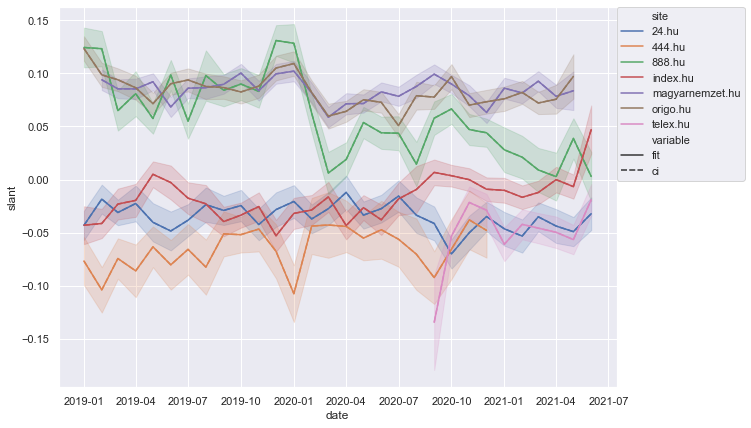

In [135]:
plot_slant(df,"slant_bymonth_1418_final_demeaned.png")

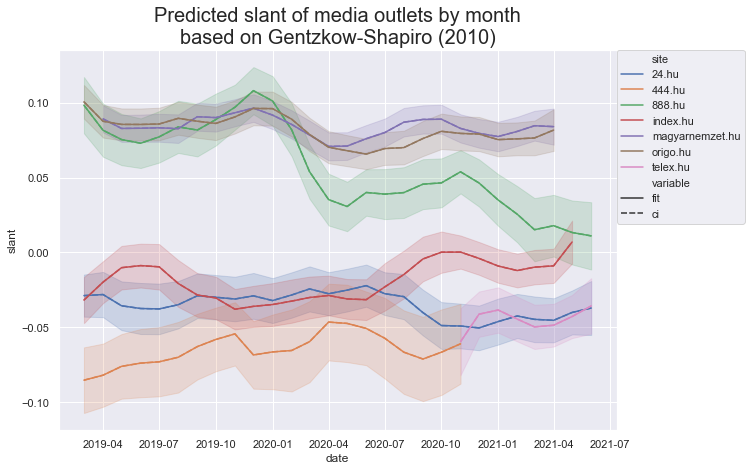

In [136]:
plot_smooth_slant(df, "slant_bymonth_1418_final_demeaned.png",rolling_window=4)

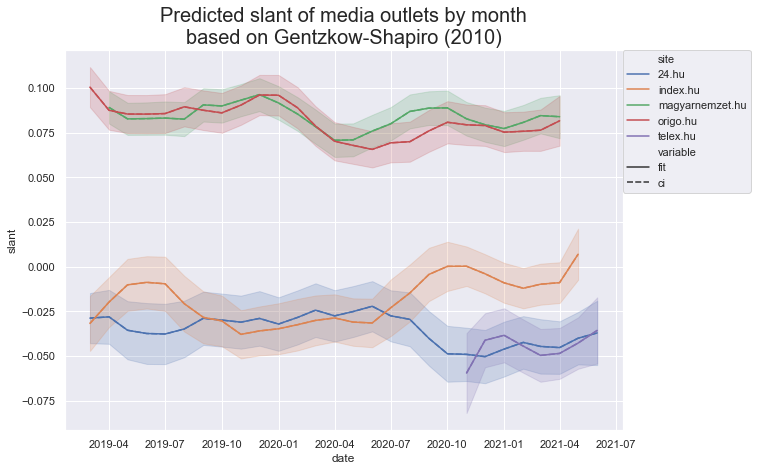

In [137]:
plot_smooth_slant(
    df.loc[lambda x: (x["site"] != "888.hu") & (x["site"] != "444.hu")],
    "slant_bymonth_1418_final_demeaned.png",
    rolling_window=4,
)